In [28]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import argparse
import time
from copy import deepcopy # Add Deepcopy for args

# Generating Dataset

In [29]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# define input sequence
raw_seq = [10*i for i in range(1000)] #[10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [batch_size, seq_len] into [seq_len, batch_size, features]
n_features = 1
X = np.swapaxes(X,0,1)
X = X.reshape((X.shape[0], X.shape[1], n_features))

print(X[:,:10,0], "\n", y[:10])

print("X.shape = {}".format(X.shape))
print("y.shape = {}".format(y.shape))

[[  0  10  20  30  40  50  60  70  80  90]
 [ 10  20  30  40  50  60  70  80  90 100]
 [ 20  30  40  50  60  70  80  90 100 110]] 
 [ 30  40  50  60  70  80  90 100 110 120]
X.shape = (3, 997, 1)
y.shape = (997,)


# Model Define

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_first = False): 
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim

        self.layer = nn.LSTM(input_size = self.input_dim, hidden_size = self.hid_dim, batch_first = batch_first)
        self.FC = nn.Linear(self.hid_dim, self.output_dim)

    def forward(self, x):
        output, (h, c) = self.layer(x)
        y = self.FC(output[-1]) # many-to-one
        return y


class LSTM_2FC(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_first = False): 
        super(LSTM_2FC, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim

        self.layer = nn.LSTM(input_size = self.input_dim, hidden_size = self.hid_dim, batch_first = batch_first)
        self.FC1 = nn.Linear(self.hid_dim, self.hid_dim//2)
        self.FC2 = nn.Linear(self.hid_dim//2, self.output_dim)

    def forward(self, x):
        output, (h, c) = self.layer(x)
        y = self.FC1(output[-1]) # many-to-one
        y = self.FC2(y)
        return y

# Model training

In [31]:
def experiment(data, args):  
    net = LSTM_2FC(args.input_dim, args.output_dim, args.hid_dim, args.batch_first)

    criterion = nn.MSELoss() # regression 문제이므로
    optimizer = optim.Adam(net.parameters(), lr = args.lr, weight_decay=args.l2 if args.l2 is not None else 0)
    
    train_losses = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        optimizer.zero_grad() 

        #print(epoch)
        input_x, true_y = data

        input_x = torch.Tensor(input_x).float()
        true_y = torch.Tensor(true_y).float()

        pred_y = net(input_x)
        #print(input_x.shape, pred_y.shape, true_y.shape)
        print(torch.squeeze(pred_y)[:5])
        print(true_y[:5])

        loss = criterion(torch.squeeze(pred_y), true_y)
        print(f'Epoch : {epoch} - loss : {loss.item()/len(true_y)}\n')
        train_losses.append(loss.item()/len(true_y))

        loss.backward()
        optimizer.step()


    # Give first starting sequence and let the model generate rest 
    test_y = np.array([10,20,30])
    for i in range(100):
        test_x = test_y[i : i + n_steps]
        test_x = test_x.reshape((n_steps, 1, n_features))
        y = net(torch.Tensor(test_x).float())
        test_y = np.append(test_y, y.view(-1).item())

    return test_y, train_losses

# Experiment

In [45]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.input_dim = 1
args.output_dim = 1 
args.hid_dim = 30
args.seq_len = n_steps

# ====== Regularization ======= #
args.l2 = 0

# ====== Optimizer & Training ====== #
args.lr = 1e-3
args.epoch = 1000
args.batch_first = False


# ====== Experiment Variable ====== #
# gen_y, train_losses = experiment((X, y), deepcopy(args))

mode = "single" # "double", None

if mode == "single" :
    name_var1 = 'hid_dim'
    list_var1 = [20, 23, 25]

    loss_df = pd.DataFrame(columns=['loss', name_var1])
    df = pd.DataFrame(columns=['gen_y', name_var1])
    for var1 in list_var1:
        setattr(args, name_var1, var1)
        print(args)
        
        ts = time.time()
        gen_y, train_losses = experiment((X, y), deepcopy(args))
        te = time.time()
        print(f'Elapsed time : {te-ts}s\n')

        newDf = pd.DataFrame({"gen_y":gen_y, name_var1:[var1]*len(gen_y)})
        df = pd.concat([df, newDf])
        loss_df = pd.concat([loss_df, pd.DataFrame({"loss":train_losses, name_var1:[var1]*len(train_losses)}) ])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tensor([30., 40., 50., 60., 70.])
Epoch : 751 - loss : 29585.2517552658

tensor([29.9042, 39.8461, 49.8032, 59.9042, 69.6987], grad_fn=<SliceBackward>)
tensor([30., 40., 50., 60., 70.])
Epoch : 752 - loss : 29576.290872617854

tensor([30.1886, 40.2190, 50.2555, 60.4659, 70.3919], grad_fn=<SliceBackward>)
tensor([30., 40., 50., 60., 70.])
Epoch : 753 - loss : 29567.3259779338

tensor([29.7871, 39.7131, 49.6327, 59.7046, 69.4650], grad_fn=<SliceBackward>)
tensor([30., 40., 50., 60., 70.])
Epoch : 754 - loss : 29558.353059177534

tensor([30.2564, 40.3303, 50.3918, 60.6490, 70.6273], grad_fn=<SliceBackward>)
tensor([30., 40., 50., 60., 70.])
Epoch : 755 - loss : 29549.376128385156

tensor([29.7023, 39.6258, 49.5346, 59.6053, 69.3502], grad_fn=<SliceBackward>)
tensor([30., 40., 50., 60., 70.])
Epoch : 756 - loss : 29540.387161484454

tensor([30.2614, 40.3307, 50.3914, 60.6659, 70.6594], grad_fn=<SliceBackward>)
tensor([30., 40., 50., 60., 70.])
Epoch : 75

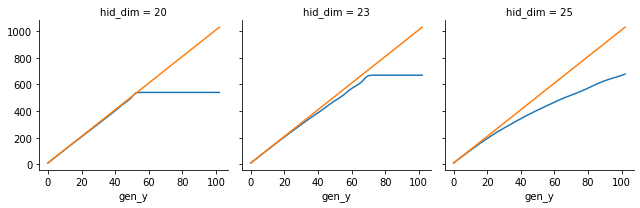

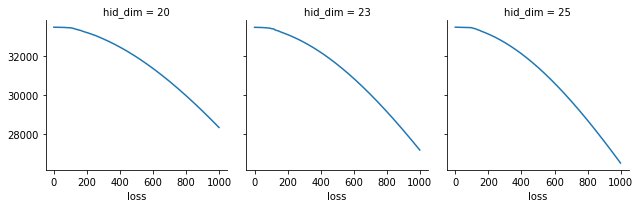

In [46]:
if mode == "single":
    # plot prediction
    g = sns.FacetGrid(df, col=name_var1)
    def dual_plot(gen_y, **kwargs):
        plt.plot(gen_y, label = "generated")
        plt.plot([10*i for i in range(1, len(gen_y)+1)], label = "y=x")
        plt.legend(loc='upper left')
    g.map(dual_plot, 'gen_y')

    # plot loss
    loss_g = sns.FacetGrid(loss_df, col=name_var1)
    loss_g.map(plt.plot, 'loss')